In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
import numpy as np
from numpy.lib import stride_tricks
import cv2
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
class PatchMatch(object):
    def __init__(self, a, b, patch_size):
        assert a.shape == b.shape, "Dimensions were unequal for patch-matching input"
        self.A = a
        self.B = b
        self.patch_size = patch_size
        self.nnf = np.zeros((2, self.A.shape[0], self.A.shape[1])).astype(np.int)
        self.nnd = np.zeros((self.A.shape[0], self.A.shape[1]))
        self.initialise_nnf()
    
    def initialise_nnf(self):
        self.nnf[0] = np.random.randint(self.B.shape[0], size=(self.A.shape[0], self.A.shape[1]))
        self.nnf[1] = np.random.randint(self.B.shape[1], size=(self.A.shape[0], self.A.shape[1]))
        self.nnf = self.nnf.transpose((1, 2 ,0))
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                pos = self.nnf[i,j]
                self.nnd[i,j] = self.cal_dist(i, j, pos[0], pos[1])

    def cal_dist(self, ai ,aj, bi, bj):
        dx0 = dy0 = self.patch_size//2
        dx1 = dy1 = self.patch_size//2 + 1
        dx0 = min(ai, bi, dx0)
        dx1 = min(self.A.shape[0]-ai, self.B.shape[0]-bi, dx1)
        dy0 = min(aj, bj, dy0)
        dy1 = min(self.A.shape[1]-aj, self.B.shape[1]-bj, dy1)
        return np.sum((self.A[ai-dx0:ai+dx1, aj-dy0:aj+dy1]-self.B[bi-dx0:bi+dx1, bj-dy0:bj+dy1])**2) / (dx1+dx0) / (dy1+dy0)
         
    def reconstruct(self):
        ans = np.zeros_like(self.A)
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                pos = self.nnf[i,j]
                ans[i,j] = self.B[pos[0], pos[1]]
        return ans
    
    def reconstruct_img_voting(self, patch_size=3,arr_v=None):
        if patch_size is None:
            patch_size = self.patch_size
        b_prime = np.zeros_like(self.A,dtype=np.uint8)

        for i in range(self.A.shape[0]): #traverse down a
            for j in range(self.A.shape[1]): #traverse across a
                
                dx0 = dy0 = patch_size//2
                dx1 = dy1 = patch_size//2 + 1
                dx0 = min(i,dx0)
                dx1 = min(self.A.shape[0]-i, dx1)
                dy0 = min(j, dy0)
                dy1 = min(self.A.shape[1]-j, dy1)
                
                votes = self.nnf[i-dx0:i+dx1, j-dy0:j+dy1] 
                b_patch = np.zeros(shape=(votes.shape[0],votes.shape[1],self.A.shape[2]))
                
                for p_i in range(votes.shape[0]):
                    for p_j in range(votes.shape[1]):
                     
                        b_patch[p_i, p_j] = self.B[votes[p_i,p_j][0] , votes[p_i,p_j][1]]

                averaged_patch = np.average(b_patch,axis=(0,1))
                b_prime[i, j] = averaged_patch[:]
        plt.imshow(b_prime[:,:,::-1])
        plt.show()
    
    def visualize_nnf(self):
        nnf = self.nnf
        nnd = self.nnd
        def angle_between_alt(p1, p2):
            ang1 = np.arctan2(*p1[::-1])
            ang2 = np.arctan2(*p2[::-1])
            return np.rad2deg((ang1 - ang2) % (2 * np.pi))

        def norm_dist(arr):
            return (arr)/(arr.max())
    
        img = np.zeros((nnf.shape[0], nnf.shape[1], 3),dtype=np.uint8)
        for i in range(1, nnf.shape[0]):
            for j in range(1, nnf.shape[1]):
                angle = angle_between_alt([j, i], [nnf[i, j][0], nnf[i, j][1]])
                img[i, j, :] = np.array([angle, nnd[i,j], 250])
        img = hsv_to_rgb(norm_dist(img/255))
        plt.imshow(img)
        plt.show()
    
    def propagate(self):
        compare_value = -1 
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                x,y = self.nnf[i,j]
                bestx, besty, bestd = x, y, self.nnd[i,j]
                
                compare_value *=-1
                
                for d in range(5): 
                    reach = 2**d
                    if (i + compare_value*reach >= 0 and compare_value == -1) or (i + compare_value*reach < self.A.shape[0] and compare_value == 1) :
                        rx, ry = self.nnf[i+compare_value*reach, j][0] , self.nnf[i+compare_value*reach, j][1]
                        if rx < self.B.shape[0]:
                            val = self.cal_dist(i, j, rx, ry)
                            if val < bestd:
                                bestx, besty, bestd = rx, ry, val

                    if (j+compare_value*reach >= 0 and compare_value == -1)or (j + compare_value*reach < self.A.shape[1] and compare_value == 1) :
                        rx, ry = self.nnf[i, j+compare_value*reach][0], self.nnf[i, j+compare_value*reach][1] 
                        if ry < self.B.shape[1]:
                            val = self.cal_dist(i, j, rx, ry)
                            if val < bestd:
                                bestx, besty, bestd = rx, ry, val
                            
                rand_d = min(self.B.shape[0]//2, self.B.shape[1]//2)
                while rand_d > 0:
                    try:
                        xmin = max(bestx - rand_d, 0)
                        xmax = min(bestx + rand_d, self.B.shape[0])
                        ymin = max(besty - rand_d, 0)
                        ymax = min(besty + rand_d, self.B.shape[1])
                    #print(xmin, xmax)
                        rx = np.random.randint(xmin, xmax)
                        ry = np.random.randint(ymin, ymax)
                        val = self.cal_dist(i, j, rx, ry)
                        if val < bestd:
                            bestx, besty, bestd = rx, ry, val
                    except:
                        print(rand_d)
                        print(xmin, xmax)
                        print(ymin, ymax)
                        print(bestx, besty)
                        print(self.B.shape)
                    rand_d = rand_d // 2

                self.nnf[i, j] = [bestx, besty]
                self.nnd[i, j] = bestd
                
        print("Done")

In [14]:
x = cv2.imread("./aa.jpg")
y = cv2.imread("./bb.jpg")

x = cv2.resize(x,(200,200))
y = cv2.resize(y,(200,200))

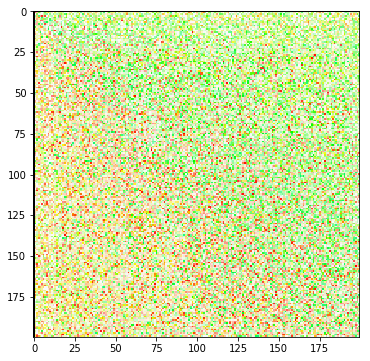

Done


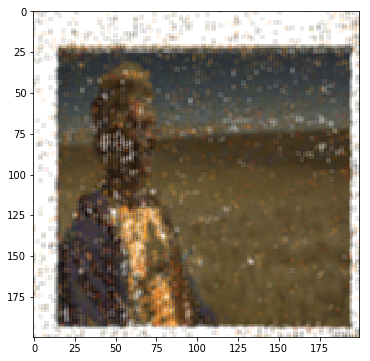

Done


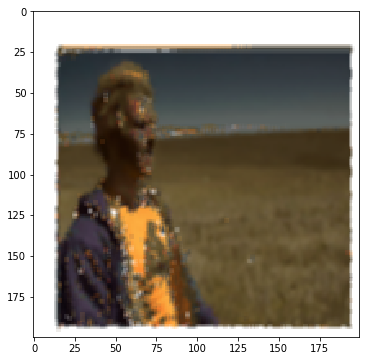

Done


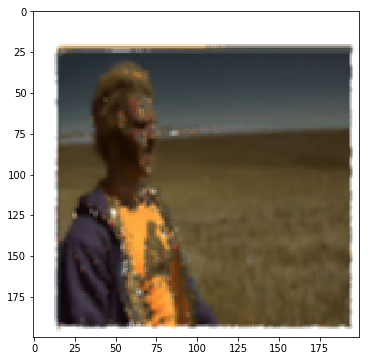

Done


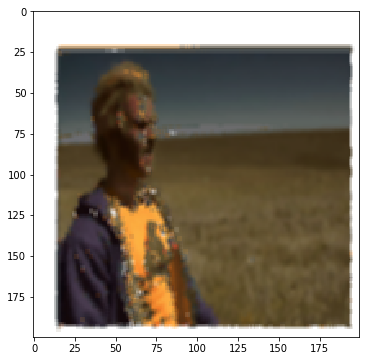

Done


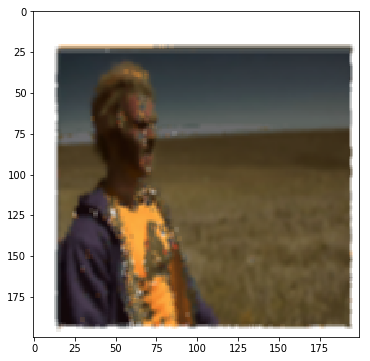

Done


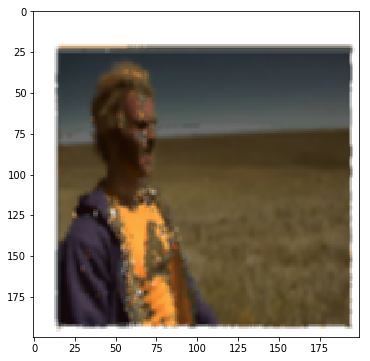

Done


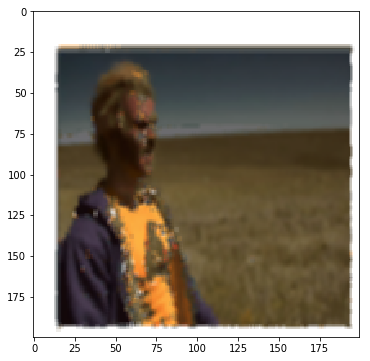

Done


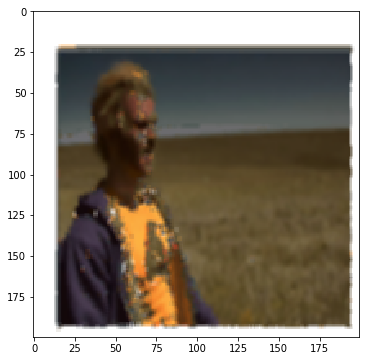

Done


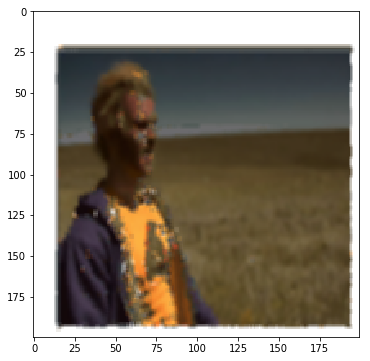

Done


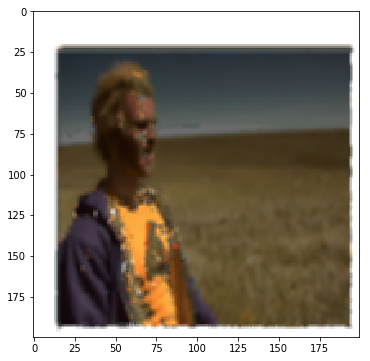

Done


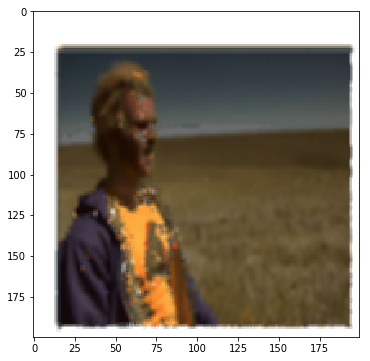

Done


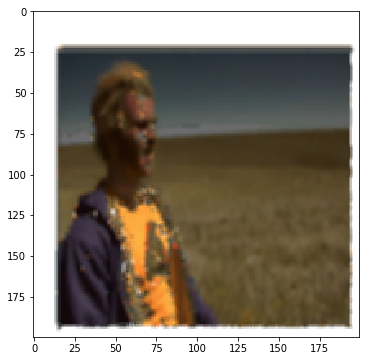

Done


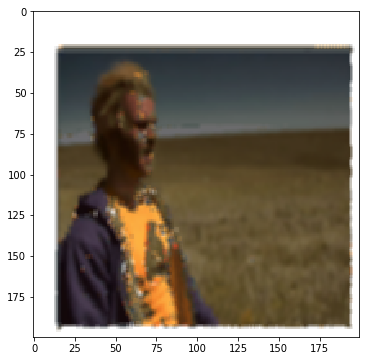

Done


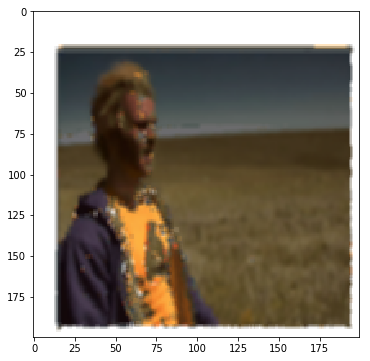

Done


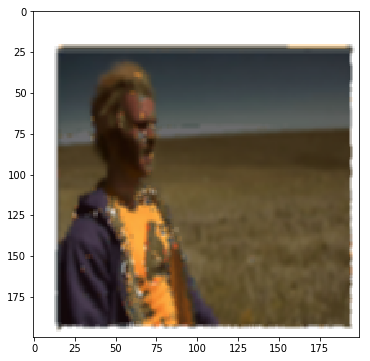

Done


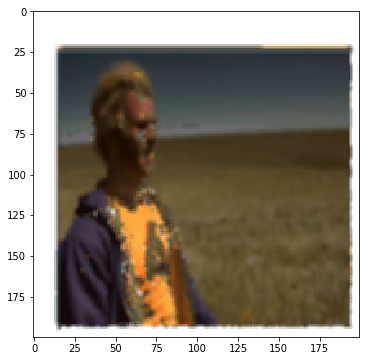

Done


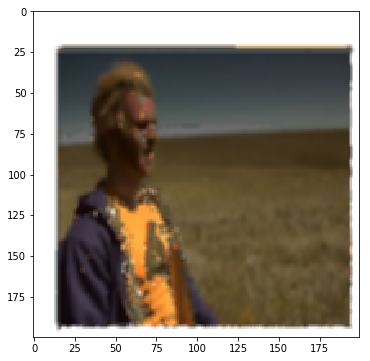

Done


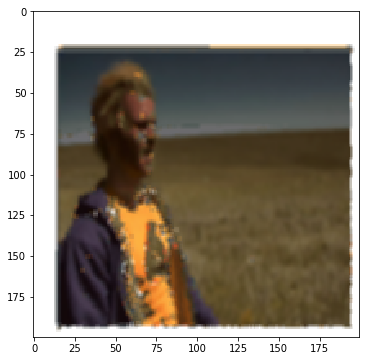

Done


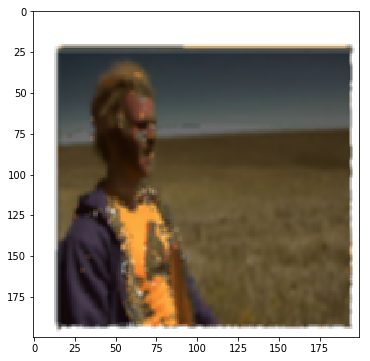

Done


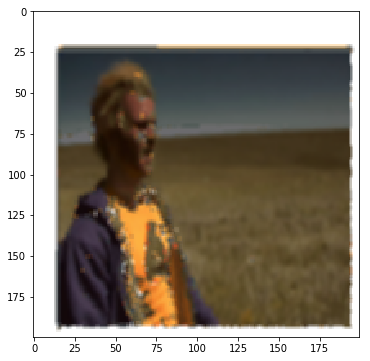

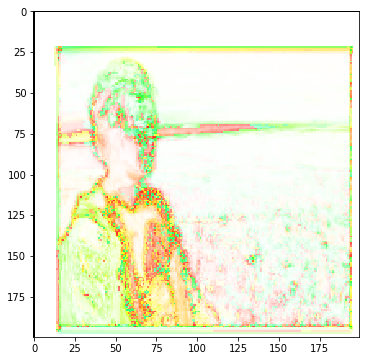

In [15]:
pm = PatchMatch(x,y, 3)
pm.visualize_nnf()
def do():
    pm.propagate()
    pm.reconstruct_img_voting(patch_size=3)
    pm.propagate()
    pm.reconstruct_img_voting(patch_size=3)
    pm.propagate()
    pm.reconstruct_img_voting(patch_size=3)
    pm.propagate()
    pm.reconstruct_img_voting(patch_size=3)

do()
do()
do()
do()
do()





pm.visualize_nnf()



# do()

In [ ]:
plt.figure(1)
plt.subplot(131)
plt.axis('off')
plt.imshow(x[:,:,::-1])

plt.subplot(132)
plt.axis('off')
plt.imshow(y[:,:,::-1])

plt.subplot(133)
plt.axis('off')
plt.imshow(pm.reconstruct()[:,:,::-1])

plt.show()

In [1]:
import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(src_dir)

In [7]:
os.path.join(os.getcwd(), os.pardir)

'/home/harsh/ml/Deep-Image-Analogy/notebooks/..'

In [17]:
from src.PatchMatch import PatchMatchSimple

Done


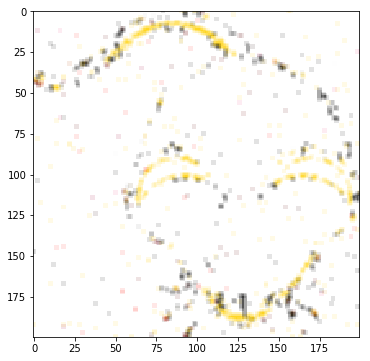

Done


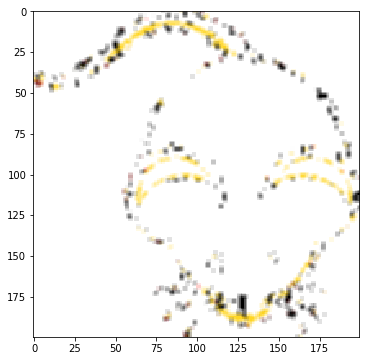

Done


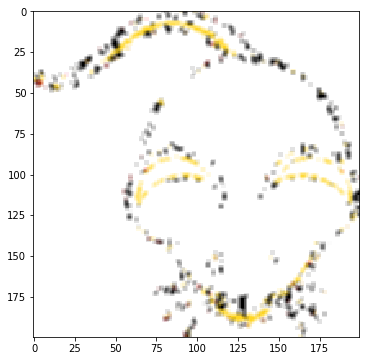

Done


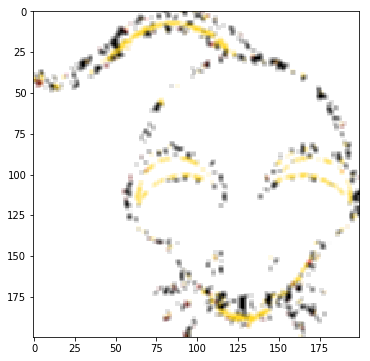

3
53 59
6 12
56 9
(200, 200, 3)
Done


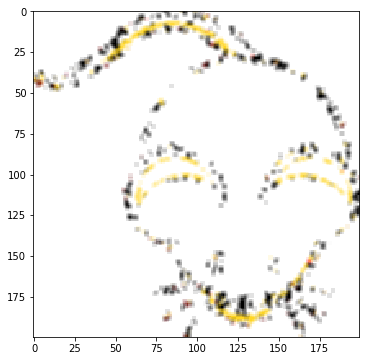

Done


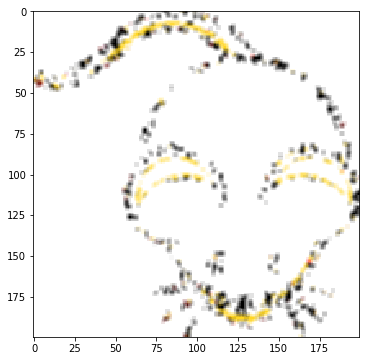

Done


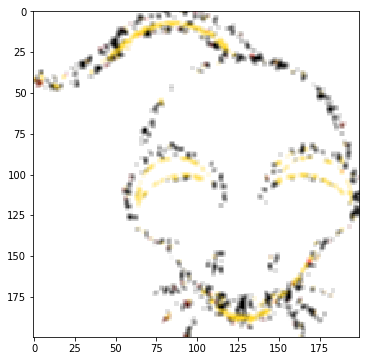

Done


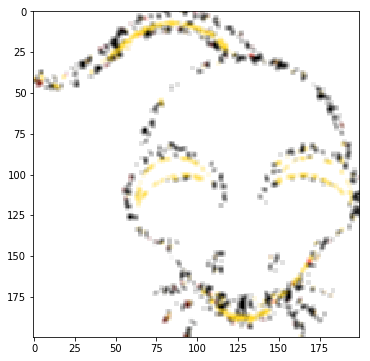

Done


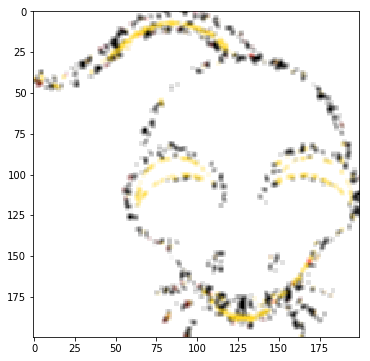

Done


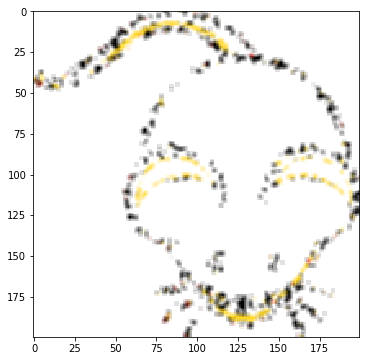

Done


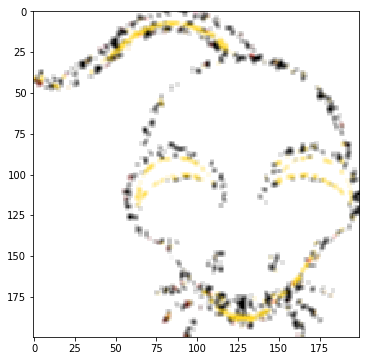

Done


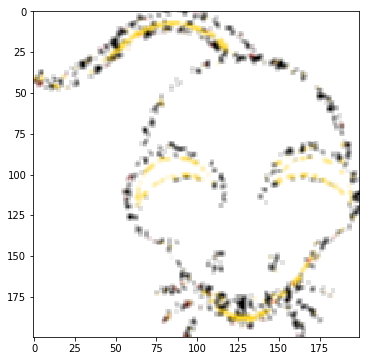

Done


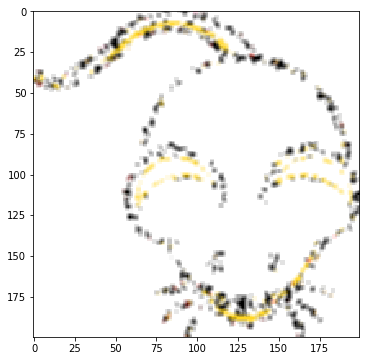

Done


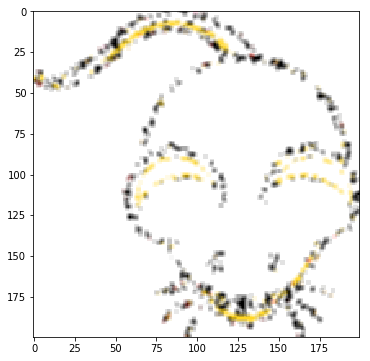

Done


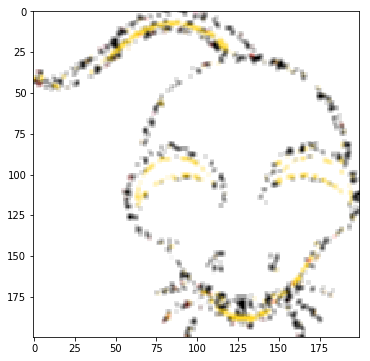

In [20]:
pm = PatchMatchSimple(x,y,patch_size=3)
for i in range(15):
    pm.propagate()
    pm.reconstruct_img_voting(patch_size=3)

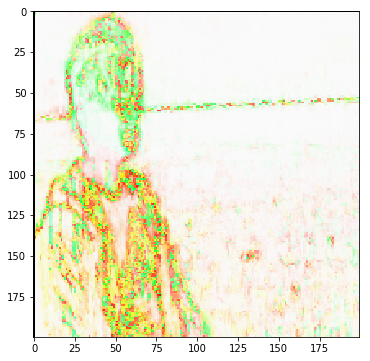

In [15]:
pm.visualize_nnf()